In [17]:
# relevent imports
import time
import torch
from torch import nn
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, balanced_accuracy_score


In [18]:
# which device were on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [19]:
# get accest to datasets for training and testing

# func for making all values to be between 1 to 0
image_normalize = lambda x : x / 255.
#one_hot = lambda t : nn.functional.one_hot(t) # not needed!
train_loader = torch.utils.data.DataLoader(datasets.MNIST('/files/', 
                                                          train=True, 
                                                          download=True, 
                                                          transform=transforms.Compose([transforms.ToTensor(), 
                                                          transforms.Lambda(image_normalize)])),                                                          
                                                          batch_size=50, 
                                                          shuffle=True)
train_images = train_loader.dataset.data / 255. # save for later plotting
train_labels = train_loader.dataset.targets
# train_loader.dataset.targets = nn.functional.one_hot(train_loader.dataset.targets)

validation_loader = torch.utils.data.DataLoader(datasets.MNIST('/files/', 
                                                          train=False, 
                                                          download=True, 
                                                          transform=transforms.Compose([transforms.ToTensor(), 
                                                          transforms.Lambda(image_normalize)])),                                                          
                                                          batch_size=50, 
                                                          shuffle=True)
validation_images = validation_loader.dataset.data / 255. # save for later plotting
validation_labels = validation_loader.dataset.targets


test_loader = torch.utils.data.DataLoader(datasets.MNIST('/files/', 
                                                          train=False, 
                                                          download=True, 
                                                          transform=transforms.Compose([transforms.ToTensor(), 
                                                          transforms.Lambda(image_normalize)])),                                                         
                                                          batch_size=50, 
                                                          shuffle=True)


test_labels = test_loader.dataset.targets
test_images = test_loader.dataset.data / 255
# test_loader.dataset.targets = nn.functional.one_hot(test_loader.dataset.targets)
print(train_labels)
# print(train_images)

tensor([5, 0, 4,  ..., 5, 6, 8])


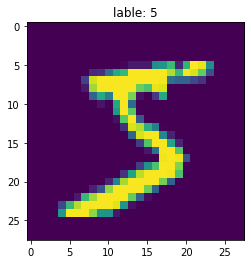

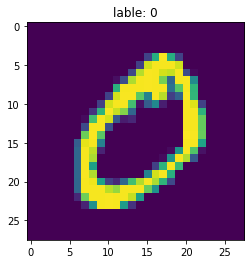

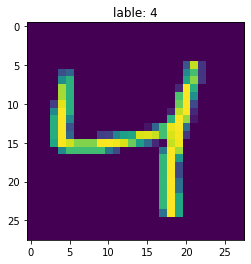

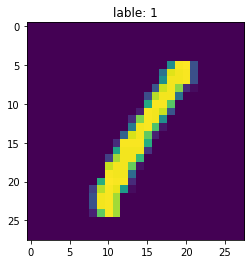

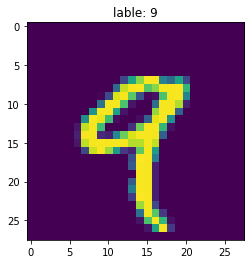

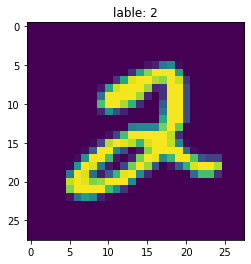

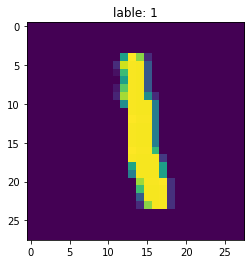

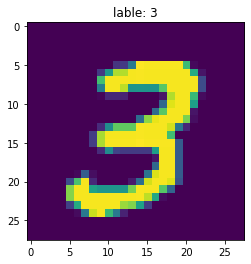

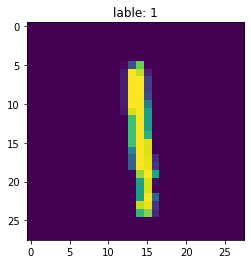

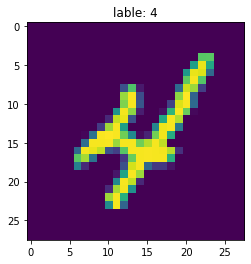

In [20]:
# print a sample of our inputs

images = 10
for i in range(images):
  plt.figure()
  imgplot = plt.imshow(train_images[i])
  # x = torch.reshape(train_images[i],(1,1,28,28))
 
  plt.title("lable: " + str(train_labels.float()[i])[-3:-2] )

In [21]:
# create models

# model with no hidden layers
model1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10), # 784 inputs  connect stright to the 10 output
)

# model with 2 hidden layers, 200 neurons each with ReLu activation func
model2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 200), # input layer to hidden layer 1
    nn.ReLU(),
    nn.Linear(200, 200), # hidden layer 1 to hidden layer 2
    nn.ReLU(),
    nn.Linear(200, 10)   # hidden layer 2 to ouput layer
)

lr = 0.01

models = [model1, model2]

In [22]:
# train models

num_images = 60000
batch_size = 50
num_baches = 13000
num_epochs = int((batch_size*num_baches)/num_images)
train_times = []

for model in models:
  
  model.to(device)
  # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  loss = torch.nn.CrossEntropyLoss()
  
  start = time.time()
  for epoch in range(num_epochs):
    print("epoch ", epoch + 1, ":")
    for batch_idx, (images, labels) in enumerate(train_loader):
      # print(model(images)[0])
      # input()
      cross_entropy = loss(model(images), labels)
      if not (batch_idx % 100):
        print(cross_entropy.detach().numpy())

      # zero gradients berfore running the backward pass
      optimizer.zero_grad()

      # backward pass to compute the gradient of loss
      # backprop + accumulate 
      cross_entropy.backward()

      # update params
      optimizer.step()

  end = time.time()
  print("Final train CE: ", loss(model(images), labels).detach().numpy())
  train_times.append(end-start)
  print("-------------------------------------------------------------")

epoch  1 :
2.300617
2.1658697
2.0117583
1.9804122
1.8075185
1.76662
1.6205611
1.5382295
1.5300297
1.4379104
1.40693
1.2780083
epoch  2 :
1.2942948
1.2569889
1.1462123
0.98040354
1.12181
1.0964922
1.0162742
0.9202406
1.0426913
0.8915261
0.8268128
0.8911528
epoch  3 :
0.8735208
0.72190374
0.922685
0.8219634
0.81713885
0.69569093
0.76164716
0.6486656
0.90356463
0.74445826
0.75196266
0.5779028
epoch  4 :
0.8175629
0.59946114
0.78735787
0.645731
0.529199
0.74110925
0.58689886
0.5607827
0.3287977
0.44901967
0.65643144
0.4204765
epoch  5 :
0.69460195
0.62472683
0.58665174
0.4020515
0.38702452
0.5669875
0.54354346
0.5487411
0.52773875
0.49864578
0.5439299
0.64563906
epoch  6 :
0.3112944
0.3456693
0.348306
0.4218336
0.46680352
0.5864179
0.46750706
0.46015713
0.9332402
0.6627614
0.36868268
0.510688
epoch  7 :
0.36825427
0.40315273
0.5623685
0.45226645
0.27261287
0.44202673
0.42709512
0.5066559
0.49863023
0.4027741
0.37195763
0.45428914
epoch  8 :
0.4735779
0.3737357
0.45162132
0.5186621
0.348884

**Validate the model:**

In [23]:
#  validation

accuracies_validation = [[],[]]
accuracies_means_validation = []

v_images = train_loader.dataset.data / 255. #  save the validation sample
v_labels = train_loader.dataset.targets
v_images = v_images[:1000]
v_labels = v_labels[:1000] 

for model in models:

  for batch_idx, (images, labels) in enumerate(train_loader):
    correct_prediction = (torch.argmax(model(images),1) == labels).type(torch.float32)
    accuracies_validation[(models.index(model))].append(torch.mean(correct_prediction))

    if batch_idx == 200: # validation on only 10000 images (like the test size)
      break

  accuracies_means_validation.append(sum(accuracies_validation[(models.index(model))])/ len(accuracies_validation[(models.index(model))]))
  print("----- Model No."+ str(models.index(model)+1) +" -----")
  print("mean of accuracies in all batches (not the general accuracy of the model): "+ str(accuracies_means_validation[(models.index(model))]))

----- Model No.1 -----
mean of accuracies in all batches (not the general accuracy of the model): tensor(0.8977)
----- Model No.2 -----
mean of accuracies in all batches (not the general accuracy of the model): tensor(0.9819)


# Evaluating the results:

In [24]:
#  test

accuracies_test = [[],[]]
accuracies_means_test = []

for model in models:

  for batch_idx, (images, labels) in enumerate(test_loader):
    correct_prediction = (torch.argmax(model(images),1) == labels).type(torch.float32)
    accuracies_test[(models.index(model))].append(torch.mean(correct_prediction))

  accuracies_means_test.append(sum(accuracies_test[(models.index(model))])/ len(accuracies_test[(models.index(model))]))
  print("----- Model No."+ str(models.index(model)+1) +" -----")
  print("mean of accuracies in all batches (not the general accuracy of the model): "+ str(accuracies_means_test[(models.index(model))]))

----- Model No.1 -----
mean of accuracies in all batches (not the general accuracy of the model): tensor(0.9064)
----- Model No.2 -----
mean of accuracies in all batches (not the general accuracy of the model): tensor(0.9688)


----- Model No.1 -----


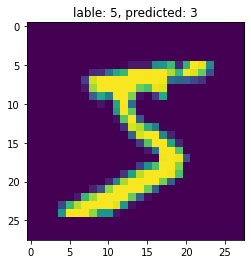

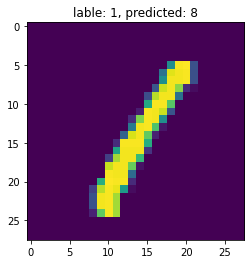

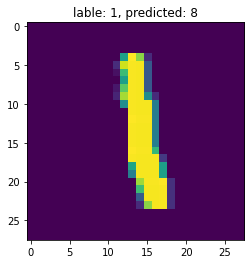

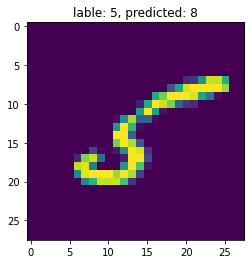

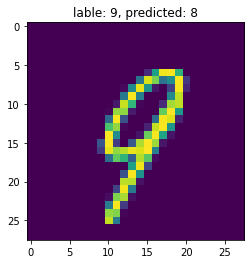

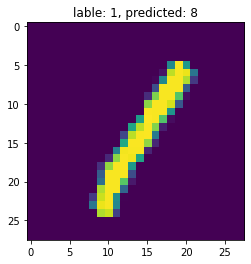

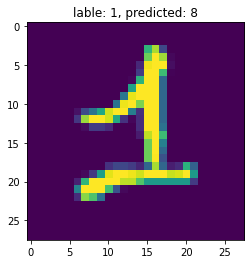

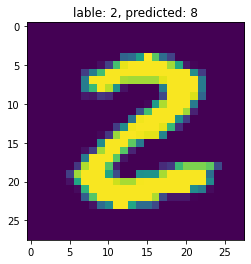

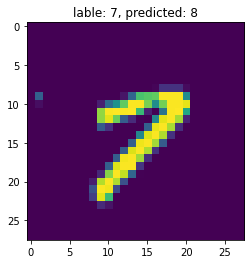

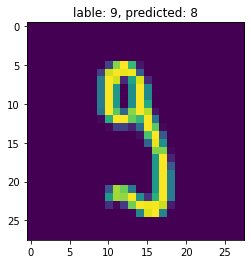

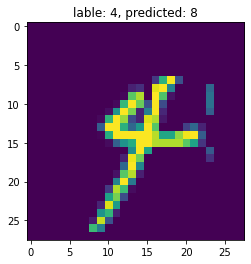

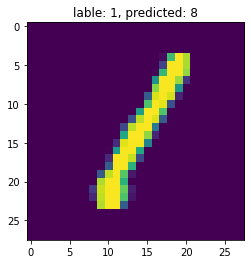

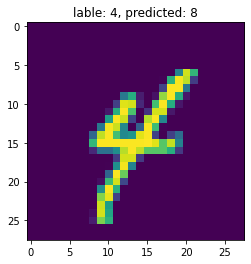

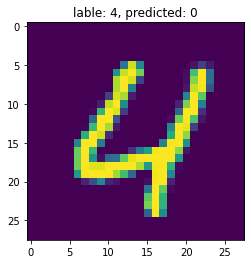

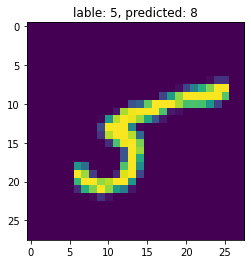

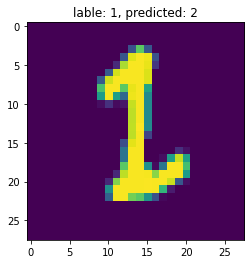

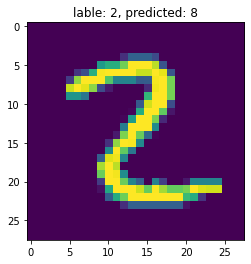

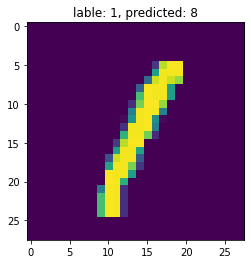

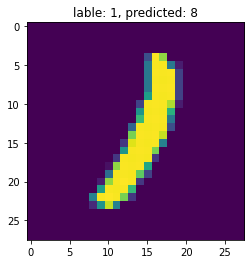

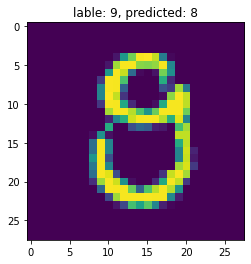

In [25]:
images = 100

print("----- Model No.1 -----")
for i in range(images):
  x = torch.reshape(train_images[i],(1,1,28,28))
  y_softmax = model1(x)
  y = torch.argmax(y_softmax, 1) # .value()
  if y != int(str(train_labels.float()[i])[-3:-2]):
    plt.figure()
    imgplot = plt.imshow(train_images[i])
    plt.title("lable: " + str(train_labels.float()[i])[-3:-2] + ", predicted: " + str(y)[-3:-2])

----- Model No.2 -----


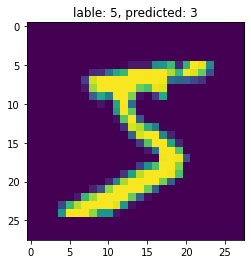

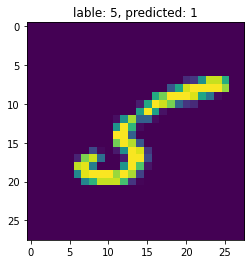

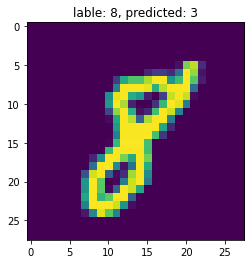

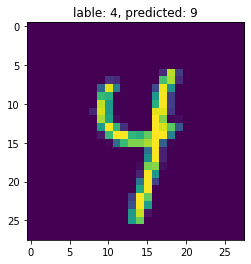

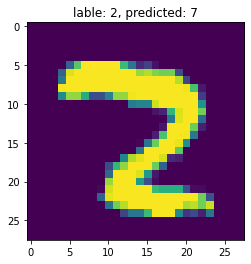

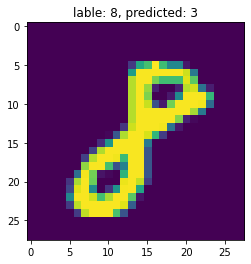

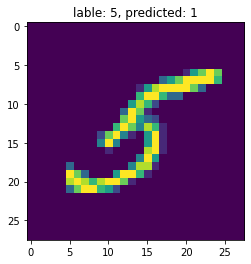

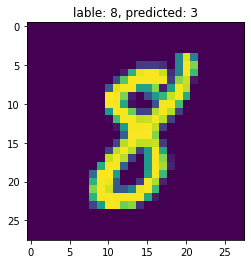

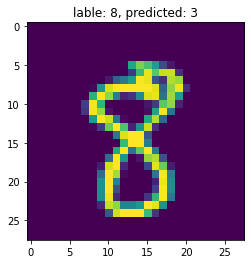

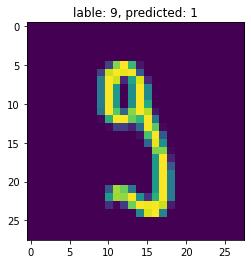

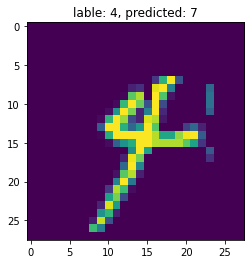

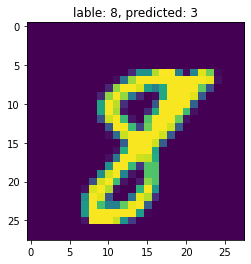

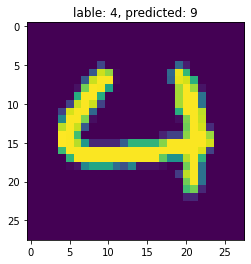

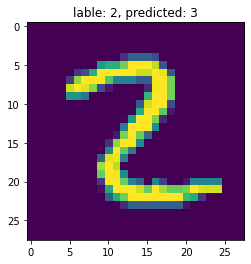

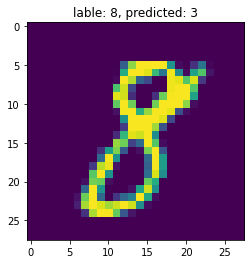

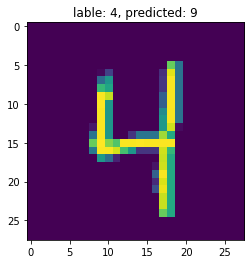

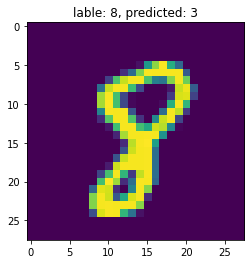

In [26]:
print("----- Model No.2 -----")
for i in range(images):
  x = torch.reshape(train_images[i],(1,1,28,28))
  y_softmax = model2(x)
  y = torch.argmax(y_softmax, 1) # .value()
  if y != int(str(train_labels.float()[i])[-3:-2]):
    plt.figure()
    imgplot = plt.imshow(train_images[i])
    plt.title("lable: " + str(train_labels.float()[i])[-3:-2] + ", predicted: " + str(y)[-3:-2])

In [27]:
def predict(trained_model, input_df, target):
  prediction = torch.argmax(trained_model(input_df),1)
  # correction_table = (prediction == target).type(torch.float32)
  return score(prediction, target)
  

def score(prediction, target):
  p_score = precision_score(target, prediction, average='macro')
  r_score = recall_score(target, prediction, average='micro')
  f_score = f1_score(target, prediction, average='micro')
  acc_score = accuracy_score(target, prediction)
  bal_acc = balanced_accuracy_score(prediction,target)
  return p_score, r_score, f_score, acc_score, bal_acc

In [28]:
p_score, r_score, f_score, acc_score, bal_acc = predict(models[0], test_images, test_labels)
print("p_score = "+ str(p_score))
print("r_score = "+ str(r_score))
print("f1_score = "+ str(f_score))
print("acc_score = "+ str(acc_score))
print("balance acc= "+ str(bal_acc))

p_score = 0.8735362134728819
r_score = 0.7688
f1_score = 0.7688
acc_score = 0.7688
balance acc= 0.8735362134728819


In [29]:
count = 0

print("------------------------------ Parameters After Training ------------------------------")
print("\n--------------- Model 1 ---------------")
print(model1)
print("\nhidden layer 1 -->")
print("\nweights:")
print(model1[1].weight.shape)
print("\nbaises:")
print(model1[1].bias.shape)
count = model1[1].weight.shape[0] * model1[1].weight.shape[1] + model1[1].bias.shape[0]
print("\nTotal count of weights and biases in the model  =  " + str(count))
print("\nTotal train time  =  " + str(train_times[0]) +" Sec")
print("\ntrain:")
p_score, r_score, f_score, acc_score, bal_acc = predict(models[0], train_images, train_labels)
print("p_score = "+ str(p_score))
print("r_score = "+ str(r_score))
print("f1_score = "+ str(f_score))
print("acc_score = "+ str(acc_score))
print("balance acc= "+ str(bal_acc))
print("\nvalidation:")
print("\nmean of accuracies in all batches: "+ str(accuracies_means_validation[0]))
p_score, r_score, f_score, acc_score, bal_acc = predict(models[0], v_images, v_labels)
print("p_score = "+ str(p_score))
print("r_score = "+ str(r_score))
print("f1_score = "+ str(f_score))
print("acc_score = "+ str(acc_score))
print("balance acc= "+ str(bal_acc))
print("\ntest:")
p_score, r_score, f_score, acc_score, bal_acc = predict(models[0], test_images, test_labels)
print("\nmean of accuracies in all batches: "+ str(accuracies_means_test[0]))
print("p_score = "+ str(p_score))
print("r_score = "+ str(r_score))
print("f1_score = "+ str(f_score))
print("acc_score = "+ str(acc_score))
print("balance acc= "+ str(bal_acc))

print("\n--------------- Model 2 ---------------")
print(model2)
print("\nhidden layer 1 -->")
print("\nweights:")
print(model2[1].weight.shape)
print("\nbaises:")
print(model2[1].bias.shape)
print("\nhidden layer 2 -->")
print("\nweights:")
print(model2[3].weight.shape)
print("\nbaises:")
print(model2[3].bias.shape)
count = model2[1].weight.shape[0] * model2[1].weight.shape[1] + model2[1].bias.shape[0]
count += model2[3].weight.shape[0] * model2[3].weight.shape[1] + model2[3].bias.shape[0]
print("\nTotal count of weights and biases in the model  =  " + str(count))
print("\nTotal train time  =  " + str(train_times[1])+" Sec")
print("\ntrain:")
p_score, r_score, f_score, acc_score, bal_acc = predict(models[1], train_images, train_labels)
print("p_score = "+ str(p_score))
print("r_score = "+ str(r_score))
print("f1_score = "+ str(f_score))
print("acc_score = "+ str(acc_score))
print("balance acc= "+ str(bal_acc))
print("\nvalidation:")
print("\nmean of accuracies in all batches: "+ str(accuracies_means_validation[1]))
p_score, r_score, f_score, acc_score, bal_acc = predict(models[1], v_images, v_labels)
print("p_score = "+ str(p_score))
print("r_score = "+ str(r_score))
print("f1_score = "+ str(f_score))
print("acc_score = "+ str(acc_score))
print("balance acc= "+ str(bal_acc))
print("\ntest:")
p_score, r_score, f_score, acc_score, bal_acc = predict(models[1], test_images, test_labels)
print("\nmean of accuracies in all batches: "+ str(accuracies_means_test[1]))
print("p_score = "+ str(p_score))
print("r_score = "+ str(r_score))
print("f1_score = "+ str(f_score))
print("acc_score = "+ str(acc_score))
print("balance acc= "+ str(bal_acc))

------------------------------ Parameters After Training ------------------------------

--------------- Model 1 ---------------
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

hidden layer 1 -->

weights:
torch.Size([10, 784])

baises:
torch.Size([10])

Total count of weights and biases in the model  =  7850

Total train time  =  103.97564744949341 Sec

train:
p_score = 0.8667427331486133
r_score = 0.76315
f1_score = 0.76315
acc_score = 0.76315
balance acc= 0.8667427331486133

validation:

mean of accuracies in all batches: tensor(0.8977)
p_score = 0.8589479252450036
r_score = 0.748
f1_score = 0.748
acc_score = 0.748
balance acc= 0.8589479252450036

test:

mean of accuracies in all batches: tensor(0.9064)
p_score = 0.8735362134728819
r_score = 0.7688
f1_score = 0.7688
acc_score = 0.7688
balance acc= 0.8735362134728819

--------------- Model 2 ---------------
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Lin

# **מה שבהמשך לא שייך לתרגול זה - התעלמו**

[https://nextjournal.com/gkoehler/pytorch-mnist](https://nextjournal.com/gkoehler/pytorch-mnist)

In [ ]:
# mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
# mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
# print(type(mnist_trainset))
# train_images = mnist_trainset.data # save for later plotting
# mnist_trainset.data = torch.flatten(mnist_trainset.data, start_dim=1, end_dim=2) / 255. # normalize
# mnist_trainset.targets = nn.functional.one_hot(mnist_trainset.targets)

# test_images = mnist_testset.data # save for later plotting
# mnist_testset.data = torch.flatten(mnist_testset.data, start_dim=1, end_dim=2) / 255.
# mnist_testset.targets = nn.functional.one_hot(mnist_testset.targets)

# print(mnist_trainset.train_data[0])
# train_data_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=100, shuffle=True)

# test_data_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=100, shuffle=False)
# print(train_data_loader)
# print(type(test_data_loader))